# Boundary Aware Loss


In [25]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import cv2
from InverseForm import InverseNet
from pathlib import Path
import numpy as np

In [26]:
def plot(image):
    image = image.squeeze().detach().numpy()
    plt.imshow(image, cmap="gray")
    plt.show()

In [27]:
label_paths = sorted(list(Path("./labels/").glob("*")))

In [42]:
class BADataset(torch.utils.data.Dataset):
    def __init__(self, path_list, size=(224,224)):
        super().__init__()
        self.path_list = path_list
        self.size = size
    
    def load_image(self, path):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image ,self.size)
        image = np.where(image>0, 1, 0)
        return image
    
    def to_tensor(self, image):
        image = torch.tensor(image, dtype=torch.float32)
        image = image.view(1,*self.size)
        return image

    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):
        image_path = self.path_list[idx]
        image = self.load_image(image_path)
        image = self.to_tensor(image)
        return image

In [43]:
dataset = BADataset(label_paths)

In [44]:
def sobel_operator(image):
    sobel_x = torch.tensor([
                [-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]
                ], dtype=torch.float32).view(1,1,3,3)
    edge_x = F.conv2d(image, sobel_x, padding=1)

    sobel_y = sobel_x.transpose(-2,-1)
    edge_y = F.conv2d(image, sobel_y, padding=1)
    edge = torch.sqrt(edge_x**2 + edge_y**2)
    edge = (edge - edge.min())/(edge.max() - edge.min())
    return edge


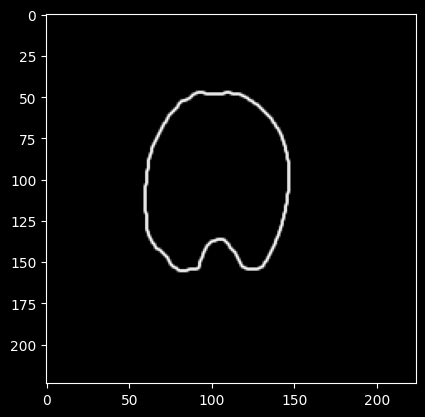

In [45]:
plot(sobel_operator(dataset[0].unsqueeze(0)))


In [47]:
image = dataset[0].unsqueeze(0) # B, C, H, W
t

torch.Size([1, 1, 224, 224])

In [117]:
import numpy as np
# テストデータの準備
def generate_affine_data(num_samples=1000, image_size=(64, 64)):
    image_pairs = []
    for _ in range(num_samples):
        imageA = np.random.rand(*image_size).astype(np.float32)
        pts1 = np.float32([[10, 10], [20, 10], [10, 20]])
        pts2 = pts1 + np.random.uniform(-5, 5, pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        imageB = cv2.warpAffine(imageA, M, image_size)
        image_pairs.append((imageA, imageB))
    return image_pairs


In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
from tqdm import tqdm
import random
# 自作のデータセットクラス
class AffineDataset(Dataset):
    def __init__(self, image_pairs, targets):
        self.image_pairs = image_pairs
        self.targets = targets

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        imageA, imageB = self.image_pairs[idx]
        target = self.targets[idx]
        return torch.tensor(imageA, dtype=torch.float32).unsqueeze(0), torch.tensor(imageB, dtype=torch.float32).unsqueeze(0), torch.tensor(target, dtype=torch.float32)

# アフィン変換行列を推定するためのモデル
class AffineEstimator(nn.Module):
    def __init__(self):
        super(AffineEstimator, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 6)  # アフィン変換行列は6要素

    def forward(self, imageA, imageB):
        x = torch.cat([imageA, imageB], dim=1)  # 2チャンネルの入力画像を結合
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # 平坦化
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 訓練関数
def train_model(model, dataloader, criterion, optimizer, num_epochs=500):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        model = model.cuda()
        running_loss = 0.0
        for imagesA, imagesB, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(imagesA.cuda(), imagesB.cuda())
            loss = criterion(outputs, targets.cuda())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imagesA.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)

    return model
# ランダムな図形を生成
def generate_random_shape(image_size=(64, 64)):
    image = np.zeros(image_size, dtype=np.float32)
    shape_type = random.choice(['circle', 'rectangle', 'triangle'])

    if shape_type == 'circle':
        center = (random.randint(15, 49), random.randint(15, 49))
        radius = random.randint(5, 15)
        cv2.circle(image, center, radius, 1, -1)

    elif shape_type == 'rectangle':
        pt1 = (random.randint(5, 30), random.randint(5, 30))
        pt2 = (random.randint(30, 59), random.randint(30, 59))
        cv2.rectangle(image, pt1, pt2, 1, -1)

    elif shape_type == 'triangle':
        pts = np.array([[random.randint(5, 59), random.randint(5, 59)],
                        [random.randint(5, 59), random.randint(5, 59)],
                        [random.randint(5, 59), random.randint(5, 59)]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(image, [pts], 1)

    return image

# テストデータの準備
def generate_affine_data(num_samples=1000, image_size=(64, 64)):
    image_pairs = []
    targets = []
    for _ in range(num_samples):
        imageA = generate_random_shape(image_size)
        pts1 = np.float32([[10, 10], [20, 10], [10, 20]])
        pts2 = pts1 + np.random.uniform(-5, 5, pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        imageB = cv2.warpAffine(imageA, M, image_size)
        image_pairs.append((imageA, imageB))
        targets.append(M.flatten()[:6])
    return image_pairs, targets

# データセットとデータローダーの作成
image_pairs, targets = generate_affine_data()
dataset = AffineDataset(image_pairs, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# モデル、損失関数、最適化手法の定義
model = AffineEstimator()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデルの訓練
trained_model = train_model(model, dataloader, criterion, optimizer)



  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:46<00:00, 10.81it/s]


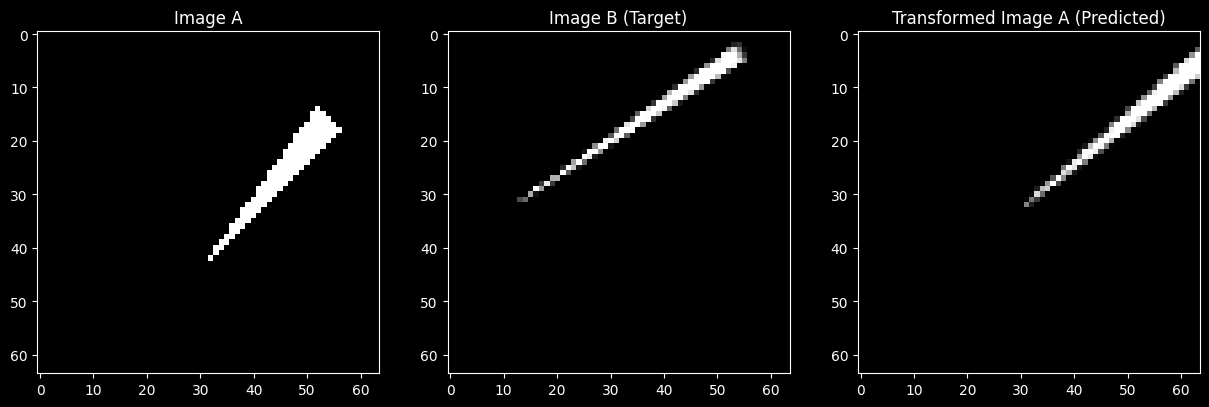

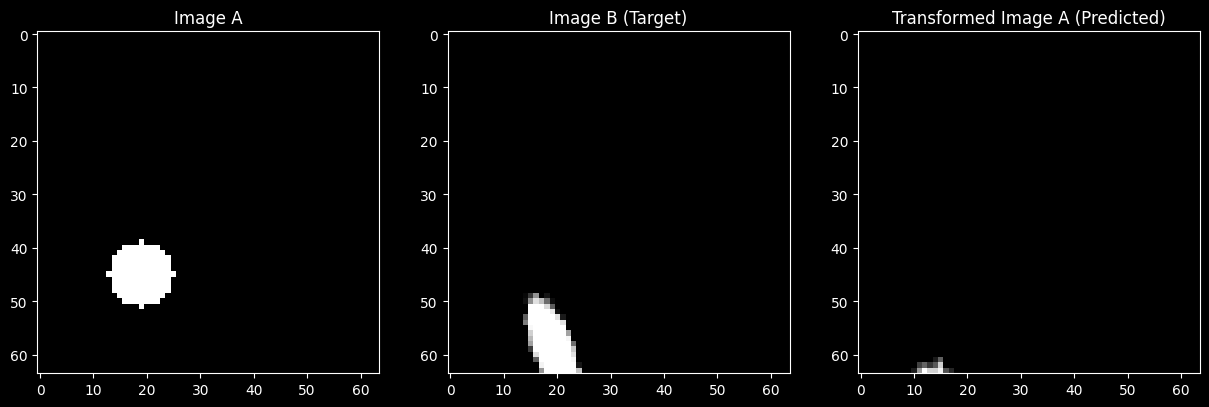

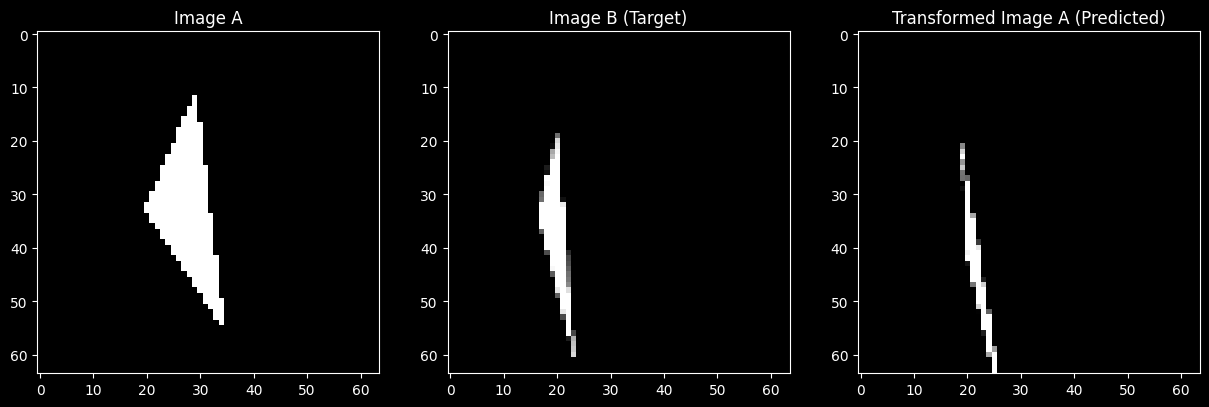

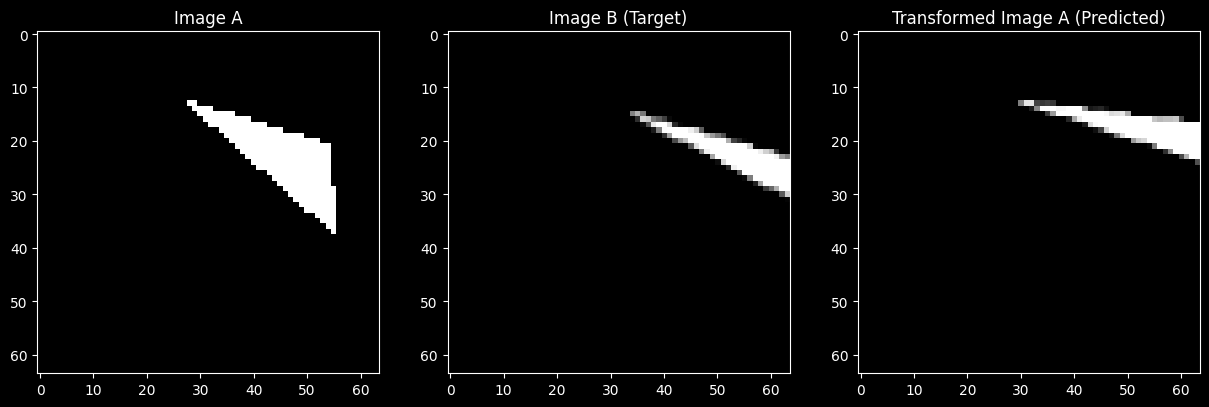

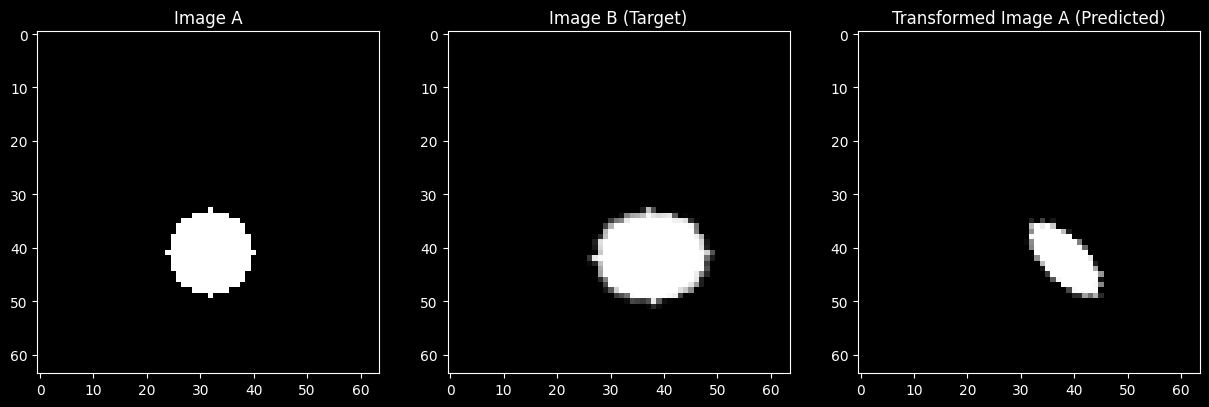

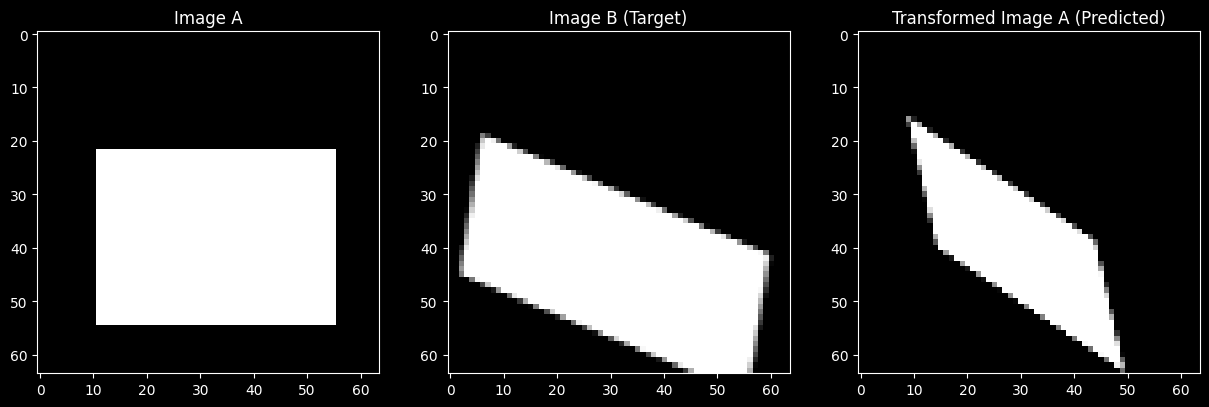

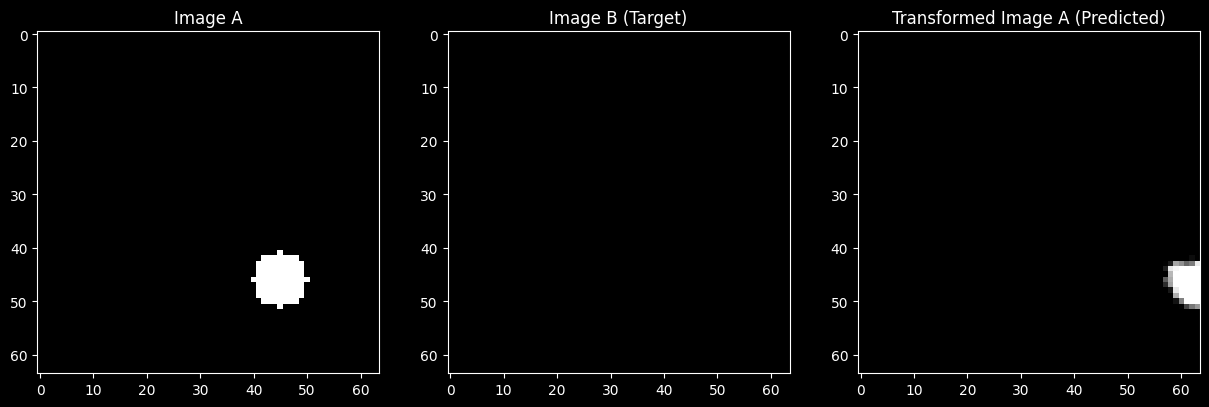

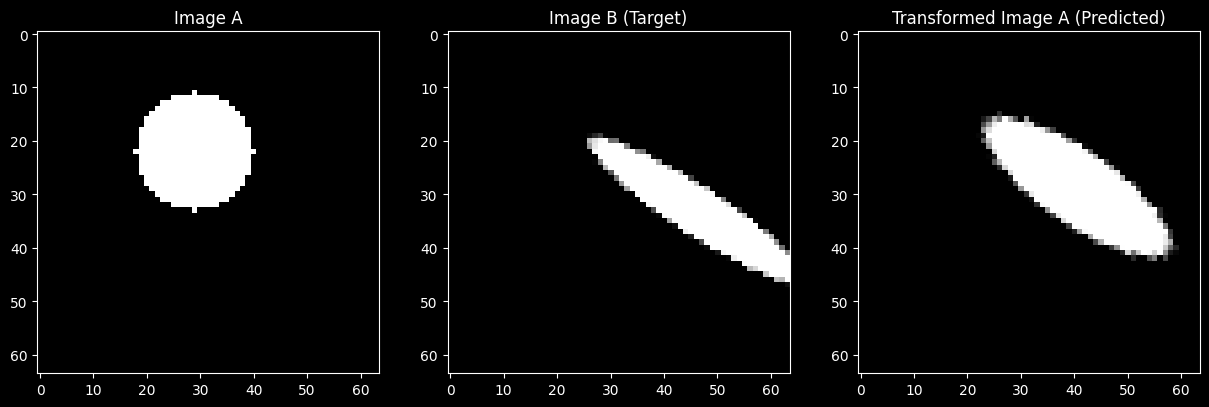

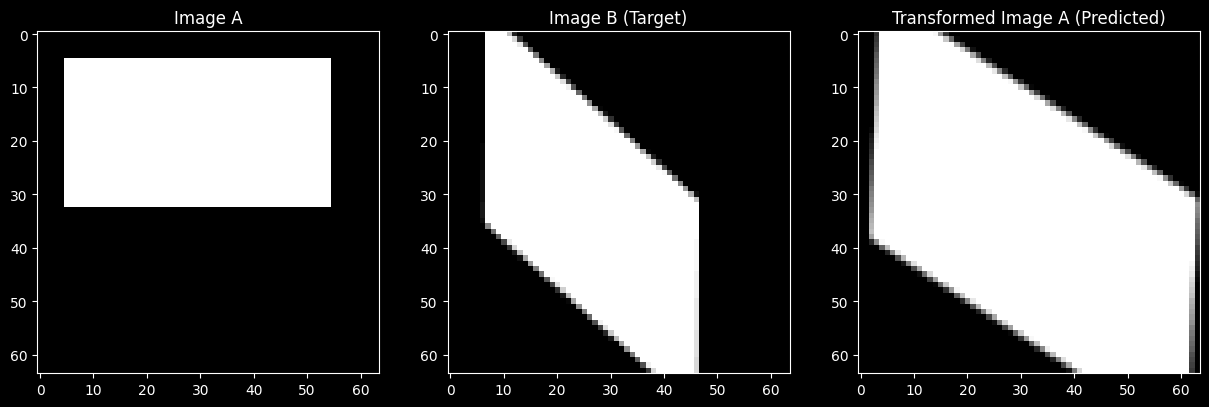

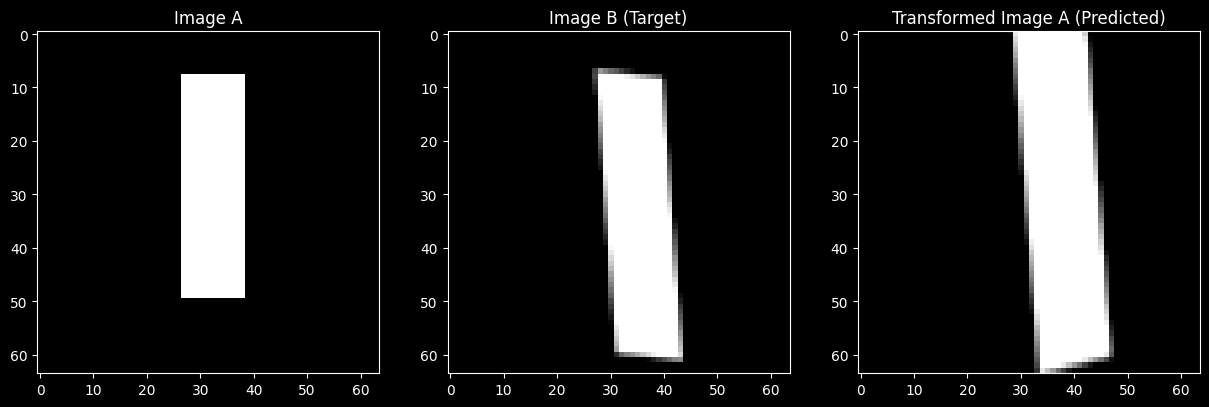

In [137]:
import matplotlib.pyplot as plt

# テストデータの生成
test_image_pairs, test_targets = generate_affine_data(num_samples=10)

# テストデータの推論とプロット
def test_and_plot(model, test_image_pairs):
    model.eval().cpu()
    with torch.no_grad():
        for i, (imageA, imageB) in enumerate(test_image_pairs):
            imageA_tensor = torch.tensor(imageA, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            imageB_tensor = torch.tensor(imageB, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            output = model(imageA_tensor, imageB_tensor).numpy().reshape(2, 3)
            
            # 予測されたアフィン変換行列を使用してimageAを変換
            transformed_imageA = cv2.warpAffine(imageA, output, (imageA.shape[1], imageA.shape[0]))

            # プロット
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(imageA, cmap='gray')
            axs[0].set_title('Image A')
            axs[1].imshow(imageB, cmap='gray')
            axs[1].set_title('Image B (Target)')
            axs[2].imshow(transformed_imageA, cmap='gray')
            axs[2].set_title('Transformed Image A (Predicted)')
            plt.show()

# テストとプロット
test_and_plot(trained_model, test_image_pairs)
